<p align="center">
  <b style="font-size:36px;">Computational Data Mining — Assignment 2</b><br>
</p>


**Goals**
- Understand Linear Independence and Collinearity.
- Practice Feature Extraction (PCA) and Feature Selection (SelectKBest, RFE).
- Analyze how feature space quality affects model stability & convergence.
- Compare derivative-based vs derivative-free/iterative optimizers.

**Datasets**
- Classification: `sklearn.datasets.load_breast_cancer()`
- Regression: `https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset`
- Clustering: `sklearn.datasets.load_iris()`

In [1]:
# ============================================================
# Section 1 — Import Required Libraries
# In this section, we load all necessary dependencies for:
# - Data handling and numerical computation
# - Machine learning model training and evaluation
# - Dimensionality reduction and feature selection
# - Clustering and classification tasks
# - Data visualization and reproducibility
# ============================================================

# ---- Standard Library ----
import time                          # Used to measure execution time of operations and models
from dataclasses import dataclass     # Helps create simple, structured data containers
from typing import Dict               # Used for clearer type annotations in function definitions

# ---- Numerics & Data Handling ----
import numpy as np                    # Core numerical computing (arrays, vectors, matrices)
import pandas as pd                   # Data manipulation and tabular data operations

# ---- Plotting & Visualization ----
import matplotlib.pyplot as plt       # Plotting graphs for analysis and model evaluation

# ---- Core Scikit-learn Utilities ----
from sklearn.model_selection import train_test_split   # Split dataset into train/test sets
from sklearn.preprocessing import StandardScaler       # Normalize features to improve model performance
from sklearn.pipeline import Pipeline                  # Create reusable ML workflows
from sklearn.metrics import mean_squared_error, silhouette_score, accuracy_score  # Evaluation metrics
from sklearn.utils.validation import check_is_fitted   # Ensures a model is trained before predicting

# ---- Feature Extraction & Selection ----
from sklearn.decomposition import PCA                  # Dimensionality reduction (Principal Component Analysis)
from sklearn.feature_selection import (
    SelectKBest, f_regression, f_classif, RFE          # Feature ranking and selection methods
)

# ---- Machine Learning Models ----
from sklearn.linear_model import LinearRegression, SGDRegressor   # Regression models
from sklearn.cluster import KMeans                                 # Clustering algorithm
from sklearn.neighbors import KNeighborsClassifier                 # K-Nearest Neighbors classifier
from sklearn.ensemble import RandomForestClassifier                # Ensemble tree-based classifier

# ---- Example Datasets ----
from sklearn.datasets import load_breast_cancer, load_iris         # Built-in datasets for testing and demonstration

# ---- Reproducibility ----
RANDOM_STATE = 2020
np.random.seed(RANDOM_STATE)              # Ensures consistent results across runs

In [2]:
# ============================================================
# Section 2 — Helper Structures and Functions
# 
# These utilities are used throughout the workflow to:
# - Measure model training and evaluation time
# - Store standardized performance results
# - Visualize matrices and PCA variance
# ============================================================

@dataclass
class FitReport:
    """
    A simple standardized container for storing model fit results.
    
    Attributes:
    ----------
    fit_time : float
        Time spent during model training (fit).
    score_time : float
        Time spent during model evaluation (score/predict).
    metric : float
        Computed performance metric (e.g., MSE, accuracy).
    extra : Dict
        Optional dictionary for storing additional details.
    """
    fit_time: float
    score_time: float
    metric: float
    extra: Dict


def timed_fit_score(model, X_train, y_train, X_test=None, y_test=None, scorer='auto'):
    """
    Train a model and measure the time required for training and scoring.
    
    Parameters:
    ----------
    model : sklearn estimator
        The model to be trained and evaluated.
    X_train, y_train : arrays
        Training data and labels (y_train can be None for unsupervised models).
    X_test, y_test : arrays, optional
        Test data and labels for evaluation.
    scorer : str
        Defines the scoring approach:
        - 'mse'      → mean squared error (lower is better)
        - 'accuracy' → classification accuracy (higher is better)
        - 'auto'     → default to model.score()

    Returns:
    -------
    FitReport : dataclass instance
        Contains fit time, score time, and performance metric.
    """
    # ----- Fit Phase -----
    t0 = time.perf_counter()
    model.fit(X_train, y_train) if y_train is not None else model.fit(X_train)
    t_fit = time.perf_counter() - t0

    # ----- Predict Phase -----
    t1 = time.perf_counter()
    metric = None
    extra = {}

    if y_test is not None and X_test is not None:
        if scorer == 'mse':
            y_pred = model.predict(X_test)
            metric = mean_squared_error(y_test, y_pred)
        elif scorer == 'accuracy':
            y_pred = model.predict(X_test)
            metric = accuracy_score(y_test, y_pred)
        else:
            metric = model.score(X_test, y_test)

    t_predict = time.perf_counter() - t1

    return FitReport(t_fit, t_predict, metric, extra)


def plot_matrix(M, title, xticklabels=None, yticklabels=None):
    """
    Display a heatmap of a matrix.
    
    Parameters:
    ----------
    M : array-like
        Matrix to visualize.
    title : str
        Plot title.
    xticklabels, yticklabels : list, optional
        Labels for x and y axes.
    """
    fig = plt.figure(figsize=(6,5))
    ax = fig.gca()
    
    # 'coolwarm' provides contrast without specifying custom colors manually
    im = ax.imshow(M, cmap='coolwarm', interpolation='nearest')
    ax.set_title(title)

    # Optional axis labeling
    if xticklabels is not None:
        ax.set_xticks(range(len(xticklabels)))
        ax.set_xticklabels(xticklabels, rotation=80, ha='right', fontsize=8)

    if yticklabels is not None:
        ax.set_yticks(range(len(yticklabels)))
        ax.set_yticklabels(yticklabels, fontsize=8)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.show()


def explained_variance_plot(pca, title="PCA — Explained Variance Ratio"):
    """
    Plot cumulative explained variance from a fitted PCA model.
    
    Parameters:
    ----------
    pca : sklearn.decomposition.PCA
        A PCA model that has already been fitted.
    title : str
        Chart title.
    """
    fig = plt.figure(figsize=(6,4))
    ax = fig.gca()

    exp_var = np.cumsum(pca.explained_variance_ratio_)
    x = range(1, len(exp_var) + 1)

    ax.plot(x, exp_var, marker='o')
    ax.set_xlabel("Components")
    ax.set_ylabel("Cumulative Explained Variance")
    ax.set_title(title)
    ax.grid(True)

    plt.tight_layout()
    plt.show()

In [3]:
# ============================================================
# Section 3 — Dataset Loading
#
# In this section, we load three datasets:
# 1) Breast Cancer (Classification)
# 2) Boston Housing (Regression)
# 3) Iris (Clustering)
#
# Each dataset is stored into separate feature matrices (X) and,
# when applicable, target vectors (y), along with feature names.
# ============================================================

# ---- Classification Dataset: Breast Cancer ----
bc = load_breast_cancer(as_frame=True)    # Load dataset as pandas DataFrame
X_cls = bc.data.copy()                    # Feature matrix
y_cls = bc.target.copy()                  # Binary target labels (malignant/benign)
feature_names_cls = X_cls.columns.tolist() # Store feature names for analysis

# ---- Regression Dataset: Boston Housing ----
# Custom version loaded from a local CSV because the built-in sklearn version is deprecated
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
boston = pd.read_csv(
    'BostonHousing.csv',
    header=None,
    delimiter=r"\s+",
    names=column_names
)

X_reg = boston.drop(columns=['MEDV']).copy()   # Feature matrix
y_reg = boston['MEDV'].copy()                  # Regression target: Median home value
feature_names_reg = X_reg.columns.tolist()

# ---- Clustering Dataset: Iris ----
iris = load_iris(as_frame=True)
X_clu = iris.data.copy()                        # Only features (unsupervised task)
feature_names_clu = X_clu.columns.tolist()

# ---- Summary Output ----
print("Shapes — classification:", X_cls.shape,
      "| regression:", X_reg.shape,
      "| clustering:", X_clu.shape)

Shapes — classification: (569, 30) | regression: (506, 13) | clustering: (150, 4)


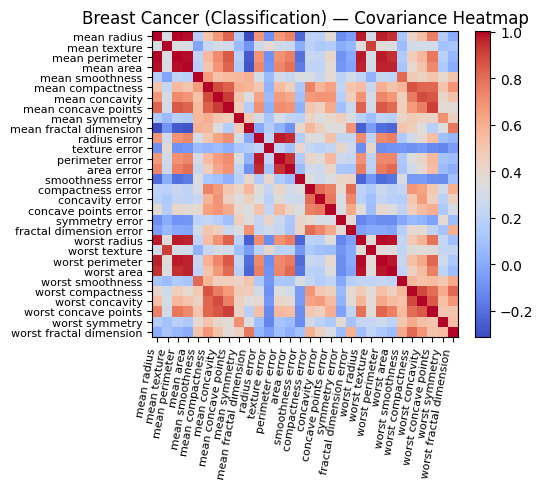

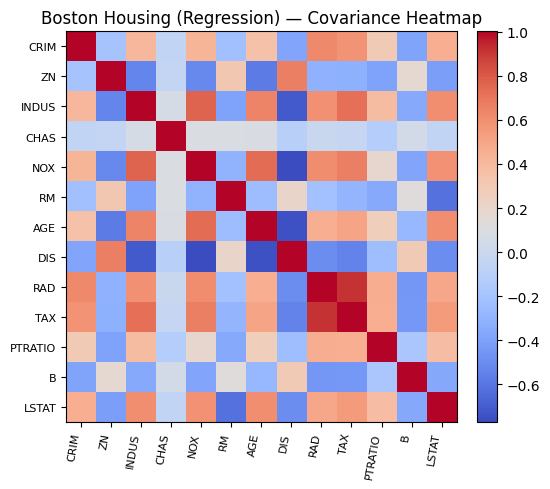

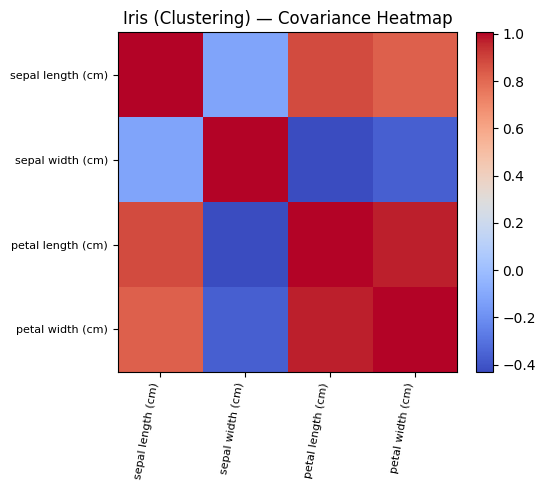

In [4]:
# ============================================================
# Section 4 — Covariance Analysis and Visualization
#
# This function standardizes each dataset (zero mean, unit variance)
# and computes the covariance matrix. Standardization ensures that
# variables measured on different scales are comparable.
#
# A heatmap is then plotted to visualize relationships between features.
# ============================================================

def covariance_and_plot(X: pd.DataFrame, title_prefix: str):
    """
    Compute the covariance matrix of a dataset (after standardization)
    and visualize it using a heatmap.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix for which the covariance matrix will be computed.
    title_prefix : str
        Descriptive label that will appear in the plot title.

    Returns
    -------
    cov : np.ndarray
        The computed covariance matrix.
    """
    
    # Standardize the dataset to ensure comparable feature scales
    Z = (X - X.mean()) / X.std(ddof=0)

    # Compute covariance matrix (columns treated as variables)
    cov = np.cov(Z.values, rowvar=False)

    # Visualize covariance structure as a heatmap
    plot_matrix(
        cov,
        title=f"{title_prefix} — Covariance Heatmap",
        xticklabels=X.columns,
        yticklabels=X.columns
    )

    return cov


# ---- Compute and Plot Covariance for Each Dataset ----
cov_cls = covariance_and_plot(X_cls, "Breast Cancer (Classification)")
cov_reg = covariance_and_plot(X_reg, "Boston Housing (Regression)")
cov_clu = covariance_and_plot(X_clu, "Iris (Clustering)")

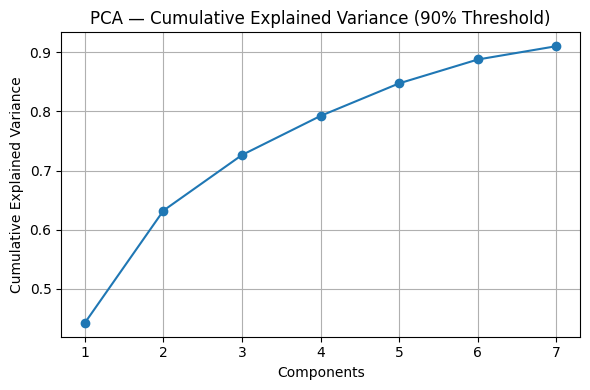

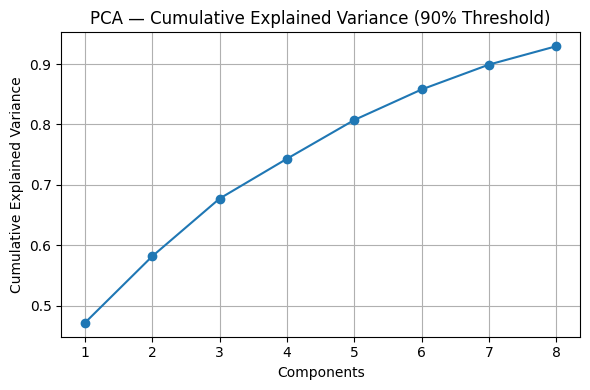

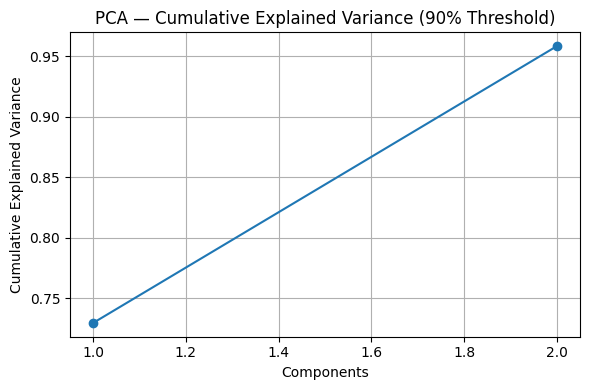

Components retained — classification / regression / clustering: 7 / 8 / 2


In [5]:
# ============================================================
# Section 5 — PCA Dimensionality Reduction
#
# In this step, we reduce the dimensionality of each dataset using PCA.
# We choose the number of components such that the transformed data
# retains at least 90% of the total variance.
#
# Benefits of PCA:
# - Removes redundancy caused by correlated features
# - Reduces noise and improves efficiency for later modeling
# - Helps with visualization and model performance in high dimensions
#
# The function below:
# 1) Standardizes the features (important for PCA)
# 2) Fits PCA with the 90% variance retention rule
# 3) Returns the transformed data, PCA model, and scaler
# 4) Plots the cumulative explained variance curve
# ============================================================

def fit_pca_90(X):
    """
    Standardize input features, fit PCA to retain at least 90% variance,
    and return the reduced feature set and PCA model.

    Parameters
    ----------
    X : pd.DataFrame
        Dataset feature matrix.

    Returns
    -------
    Xp : np.ndarray
        Transformed features in lower-dimensional PCA space.
    pca : PCA object
        Fitted PCA model.
    scaler : StandardScaler object
        Scaler used to standardize the data (needed if inverse transforming).
    """
    
    # Standardize the dataset (PCA requires scale normalization)
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Fit PCA with minimum 90% retained variance
    pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(Xs)

    # Visualize variance explained by PCA components
    explained_variance_plot(
        pca,
        title="PCA — Cumulative Explained Variance (90% Threshold)"
    )

    return Xp, pca, scaler


# ---- Apply PCA to Each Dataset ----
Xp_cls, pca_cls, scaler_cls = fit_pca_90(X_cls)  # Classification dataset
Xp_reg, pca_reg, scaler_reg = fit_pca_90(X_reg)  # Regression dataset
Xp_clu, pca_clu, scaler_clu = fit_pca_90(X_clu)  # Clustering dataset

# ---- Show the number of retained components ----
print("Components retained — classification / regression / clustering:",
      Xp_cls.shape[1], "/", Xp_reg.shape[1], "/", Xp_clu.shape[1])


In [6]:
# ============================================================
# Section 6 — Feature Selection
#
# We now perform feature selection using two approaches:
#
# 1) SelectKBest (SKB):
#    - Ranks features using statistical tests.
#    - For classification → ANOVA F-test (f_classif)
#    - For regression → Linear correlation F-test (f_regression)
#
# 2) Recursive Feature Elimination (RFE):
#    - Fits a model and eliminates the least important features iteratively.
#    - For classification, we use RandomForest (handles nonlinear relationships).
#    - For regression, we use LinearRegression (simple and interpretable).
#
# To ensure a fair comparison with PCA, we select the same number
# of features as the number of PCA components retained (≈ 90% variance).
# ============================================================

# Number of features to keep = number of PCA components retained
k_cls = Xp_cls.shape[1]   # For classification dataset
k_reg = Xp_reg.shape[1]   # For regression dataset

# ---- Classification — SelectKBest ----
skb_cls = Pipeline([
    ('scaler', StandardScaler()),                     # Standardize input features
    ('skb', SelectKBest(score_func=f_classif, k=k_cls))  # Select top k informative features
])
X_skb_cls = skb_cls.fit_transform(X_cls, y_cls)

# ---- Regression — SelectKBest ----
skb_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('skb', SelectKBest(score_func=f_regression, k=k_reg))
])
X_skb_reg = skb_reg.fit_transform(X_reg, y_reg)

# ---- Regression — RFE (using LinearRegression) ----
rfe_reg_estimator = LinearRegression()
rfe_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=rfe_reg_estimator, n_features_to_select=k_reg))
])
X_rfe_reg = rfe_reg.fit_transform(X_reg, y_reg)

# ---- Classification — RFE (using RandomForest for robustness) ----
rfe_cls_estimator = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rfe_cls = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=rfe_cls_estimator,
                n_features_to_select=k_cls,
                step=0.2))   # Remove 20% of features each iteration
])
X_rfe_cls = rfe_cls.fit_transform(X_cls, y_cls)

# ---- Summary of resulting dataset shapes ----
print("Selected shapes — CLS (SKB / RFE):", X_skb_cls.shape, "/", X_rfe_cls.shape)
print("Selected shapes — REG (SKB / RFE):", X_skb_reg.shape, "/", X_rfe_reg.shape)

Selected shapes — CLS (SKB / RFE): (569, 7) / (569, 7)
Selected shapes — REG (SKB / RFE): (506, 8) / (506, 8)


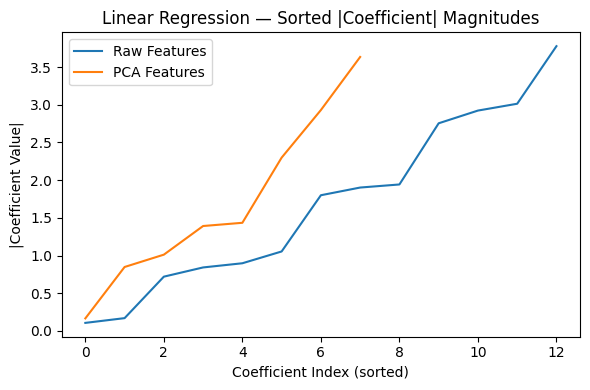

LinearRegression MSE — Raw: 20.6048, PCA: 24.6336
Fit time (s) — Raw: 0.0041, PCA: 0.0043


In [7]:
# ============================================================
# Section 7 — Regression Model Comparison (Raw vs PCA)
#
# We evaluate how PCA-based dimensionality reduction affects:
# - Model accuracy (Mean Squared Error)
# - Training speed
# - Coefficient stability (sensitivity to multicollinearity)
#
# We compare:
#   1) Linear Regression on raw (scaled) features
#   2) Linear Regression on PCA-transformed features
# ============================================================

# ---- Train/Test Split for Regression Dataset ----
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg,
    test_size=0.25,
    random_state=RANDOM_STATE
)

# ---- Linear Regression (Raw Features) ----
lin_raw = Pipeline([
    ('scaler', StandardScaler()),   # Standardize features
    ('lin', LinearRegression())     # Closed-form linear regression
])

# ---- Linear Regression (PCA-Reduced Features) ----
lin_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_reg.n_components_, random_state=RANDOM_STATE)),
    ('lin', LinearRegression())
])

# ---- Train and Evaluate Both Models ----
rep_lin_raw = timed_fit_score(lin_raw, Xr_train, yr_train, Xr_test, yr_test, scorer='mse')
rep_lin_pca = timed_fit_score(lin_pca, Xr_train, yr_train, Xr_test, yr_test, scorer='mse')

def coef_vector_from_pipeline(pipeline):
    """
    Extract linear regression coefficients (if available).
    Returns None if estimator is not fitted or unavailable.
    """
    try:
        lin = pipeline.named_steps.get('lin')
        check_is_fitted(lin)
        return lin.coef_.ravel()
    except Exception:
        return None

coefs_raw = coef_vector_from_pipeline(lin_raw)
coefs_pca = coef_vector_from_pipeline(lin_pca)

# ---- Qualitative Comparison Plot ----
if coefs_raw is not None and coefs_pca is not None:
    fig = plt.figure(figsize=(6,4))
    ax = fig.gca()
    ax.plot(sorted(np.abs(coefs_raw)), label='Raw Features')
    ax.plot(sorted(np.abs(coefs_pca)), label='PCA Features')
    ax.set_title('Linear Regression — Sorted |Coefficient| Magnitudes')
    ax.set_xlabel('Coefficient Index (sorted)')
    ax.set_ylabel('|Coefficient Value|')
    ax.legend()
    plt.tight_layout()
    plt.show()

print(f"LinearRegression MSE — Raw: {rep_lin_raw.metric:.4f}, PCA: {rep_lin_pca.metric:.4f}")
print(f"Fit time (s) — Raw: {rep_lin_raw.fit_time:.4f}, PCA: {rep_lin_pca.fit_time:.4f}")

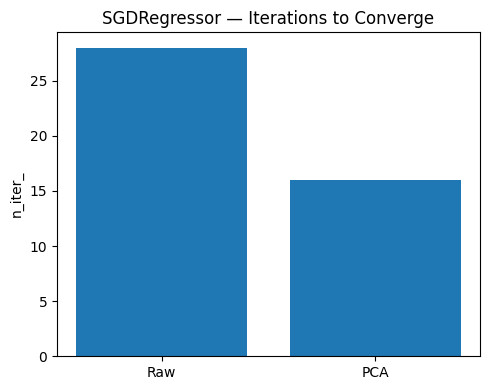

SGDRegressor MSE — Raw: 20.8808, PCA: 24.7824
SGDRegressor n_iter_ — Raw: 28, PCA: 16


In [8]:
# ============================================================
# Section 8 — Stochastic Gradient Descent Regression (Raw vs PCA)
#
# Here we evaluate how PCA affects:
# - Convergence speed (# of iterations)
# - Model performance (MSE)
# - Training efficiency
#
# Why SGD?
# - Useful for large datasets and online learning
# - Sensitive to feature scaling and redundant dimensions
# - PCA can improve convergence stability
# ============================================================

# ---- SGD Regression on Raw Features ----
sgd_raw = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDRegressor(
        random_state=RANDOM_STATE,
        max_iter=2000,
        tol=1e-3,
        learning_rate='invscaling',
        eta0=0.01
    ))
])

# ---- SGD Regression on PCA-Reduced Features ----
sgd_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=pca_reg.n_components_, random_state=RANDOM_STATE)),
    ('sgd', SGDRegressor(
        random_state=RANDOM_STATE,
        max_iter=2000,
        tol=1e-3,
        learning_rate='invscaling',
        eta0=0.01
    ))
])

# ---- Train and Evaluate Both Models ----
rep_sgd_raw = timed_fit_score(sgd_raw, Xr_train, yr_train, Xr_test, yr_test, scorer='mse')
rep_sgd_pca = timed_fit_score(sgd_pca, Xr_train, yr_train, Xr_test, yr_test, scorer='mse')

def get_n_iter_from_pipeline(pipe, step_name='sgd'):
    """
    Extract the number of iterations SGD used until convergence.
    Returns None if the estimator is not fitted or attribute missing.
    """
    try:
        est = pipe.named_steps[step_name]
        check_is_fitted(est)
        return getattr(est, 'n_iter_', None)
    except Exception:
        return None

niter_raw = get_n_iter_from_pipeline(sgd_raw)
niter_pca = get_n_iter_from_pipeline(sgd_pca)

# ---- Visual Comparison ----
iters = [
    niter_raw if niter_raw is not None else 0,
    niter_pca if niter_pca is not None else 0
]
labels = ['Raw', 'PCA']

fig = plt.figure(figsize=(5,4))
ax = fig.gca()
ax.bar(labels, iters)
ax.set_title('SGDRegressor — Iterations to Converge')
ax.set_ylabel('n_iter_')
plt.tight_layout()
plt.show()

print(f"SGDRegressor MSE — Raw: {rep_sgd_raw.metric:.4f}, PCA: {rep_sgd_pca.metric:.4f}")
print(f"SGDRegressor n_iter_ — Raw: {niter_raw}, PCA: {niter_pca}")

k=2  |  Raw: inertia=152.35, silhouette=0.681, iters=3, time=0.1791s  ||  PCA(2): inertia=137.16, silhouette=0.706, iters=3, time=0.0175s


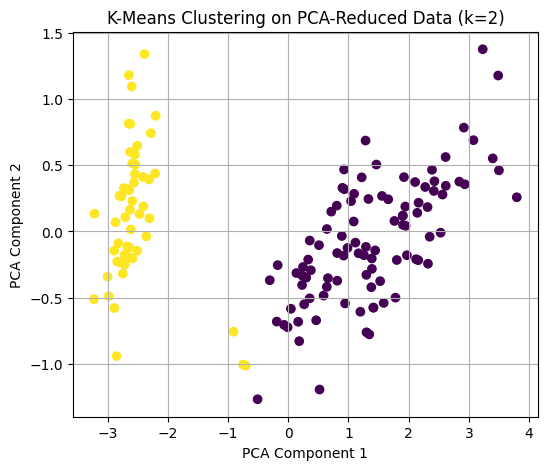

k=3  |  Raw: inertia=78.85, silhouette=0.553, iters=4, time=0.0452s  ||  PCA(2): inertia=63.82, silhouette=0.598, iters=8, time=0.0215s


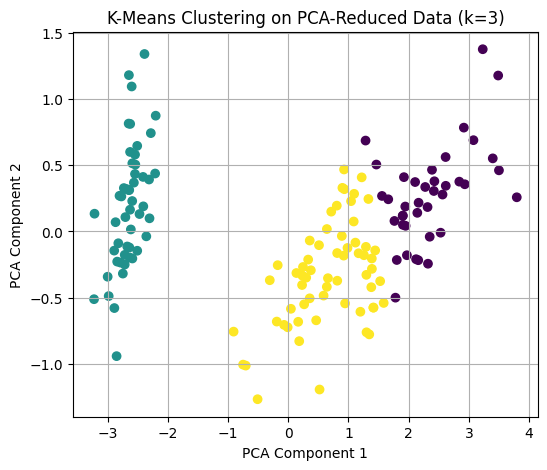

In [9]:
# ============================================================
# Section 9 — K-Means Clustering (Raw vs PCA-Reduced Iris Data)
#
# We compare clustering performance before and after PCA.
#
# Metrics used:
# - Inertia (↓ lower is better → tighter clusters)
# - Silhouette Score (↑ higher is better → well-separated clusters)
# - Number of iterations to converge (↓ fewer → faster convergence)
# - Runtime (↓ faster = more efficient)
#
# We test different cluster counts k = {2, 3}:
# ============================================================

for k in [2, 3]:

    # ---- K-Means on Raw Features ----
    km_raw = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    t0 = time.perf_counter()
    km_raw.fit(X_clu)
    t_raw = time.perf_counter() - t0

    inertia_raw = km_raw.inertia_
    sil_raw = silhouette_score(X_clu, km_raw.labels_)
    niter_raw = km_raw.n_iter_

    # ---- K-Means on PCA-Reduced Features (2D for visualization) ----
    pca2 = PCA(n_components=min(2, Xp_clu.shape[1]), random_state=RANDOM_STATE)
    Xp2 = pca2.fit_transform(X_clu)

    km_pca = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    t1 = time.perf_counter()
    km_pca.fit(Xp2)
    t_pca = time.perf_counter() - t1

    inertia_pca = km_pca.inertia_
    sil_pca = silhouette_score(Xp2, km_pca.labels_)
    niter_pca = km_pca.n_iter_

    # ---- Performance Summary for Current k ----
    print(
        f"k={k}  |  "
        f"Raw: inertia={inertia_raw:.2f}, silhouette={sil_raw:.3f}, iters={niter_raw}, time={t_raw:.4f}s"
        f"  ||  PCA(2): inertia={inertia_pca:.2f}, silhouette={sil_pca:.3f}, iters={niter_pca}, time={t_pca:.4f}s"
    )

    # ---- Visualization — Cluster Labels in PCA Space ----
    plt.figure(figsize=(6,5))
    plt.scatter(Xp2[:, 0], Xp2[:, 1], c=km_pca.labels_)
    plt.title(f"K-Means Clustering on PCA-Reduced Data (k={k})")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

In [10]:
# ============================================================
# Section 10 - Classification Benchmark: Raw vs PCA vs SelectKBest
# Dataset: Breast Cancer
# Models: KNN (k=5) and RandomForest (200 estimators)
#
# We compare:
# - Accuracy on validation set
# - Fit time (training)
# - Predict time (inference)
# ============================================================

# Train/Validation split (stratified to preserve class balance)
Xc_train, Xc_val, yc_train, yc_val = train_test_split(
    X_cls, y_cls,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=y_cls
)


# ------------------------------------------------------------
# KNN Model Variants
# ------------------------------------------------------------
def eval_knn_variants():
    results = []

    # ---- Raw Features ----
    knn_raw = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    t0 = time.perf_counter(); knn_raw.fit(Xc_train, yc_train); fit_t = time.perf_counter() - t0
    t1 = time.perf_counter(); ypred = knn_raw.predict(Xc_val); pred_t = time.perf_counter() - t1
    acc = accuracy_score(yc_val, ypred)
    results.append(("Raw", acc, fit_t, pred_t))

    # ---- PCA Features ----
    knn_pca = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca_cls.n_components_, random_state=RANDOM_STATE)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    t0 = time.perf_counter(); knn_pca.fit(Xc_train, yc_train); fit_t = time.perf_counter() - t0
    t1 = time.perf_counter(); ypred = knn_pca.predict(Xc_val); pred_t = time.perf_counter() - t1
    acc = accuracy_score(yc_val, ypred)
    results.append(("PCA", acc, fit_t, pred_t))

    # ---- SelectKBest Features ----
    skb = Pipeline([
        ('scaler', StandardScaler()),
        ('skb', SelectKBest(score_func=f_classif, k=pca_cls.n_components_)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    t0 = time.perf_counter(); skb.fit(Xc_train, yc_train); fit_t = time.perf_counter() - t0
    t1 = time.perf_counter(); ypred = skb.predict(Xc_val); pred_t = time.perf_counter() - t1
    acc = accuracy_score(yc_val, ypred)
    results.append(("SelectKBest", acc, fit_t, pred_t))

    return results


# ------------------------------------------------------------
# RandomForest Model Variants
# ------------------------------------------------------------
def eval_rf_variants():
    results = []
    rf_base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

    # ---- Raw Features ----
    rf_raw = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', rf_base)
    ])
    rep_raw = timed_fit_score(rf_raw, Xc_train, yc_train, Xc_val, yc_val, scorer='accuracy')
    results.append(("Raw", rep_raw.metric, rep_raw.fit_time, rep_raw.score_time))

    # ---- PCA Features ----
    rf_pca = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca_cls.n_components_, random_state=RANDOM_STATE)),
        ('rf', rf_base)
    ])
    rep_pca = timed_fit_score(rf_pca, Xc_train, yc_train, Xc_val, yc_val, scorer='accuracy')
    results.append(("PCA", rep_pca.metric, rep_pca.fit_time, rep_pca.score_time))

    # ---- SelectKBest Features ----
    rf_skb = Pipeline([
        ('scaler', StandardScaler()),
        ('skb', SelectKBest(score_func=f_classif, k=pca_cls.n_components_)),
        ('rf', rf_base)
    ])
    rep_skb = timed_fit_score(rf_skb, Xc_train, yc_train, Xc_val, yc_val, scorer='accuracy')
    results.append(("SelectKBest", rep_skb.metric, rep_skb.fit_time, rep_skb.score_time))

    return results


# ------------------------------------------------------------
# Run and Display Results
# ------------------------------------------------------------
knn_results = eval_knn_variants()
rf_results = eval_rf_variants()

knn_df = pd.DataFrame(knn_results, columns=["Variant", "Accuracy", "FitTime(s)", "PredictTime(s)"])
rf_df = pd.DataFrame(rf_results, columns=["Variant", "Accuracy", "FitTime(s)", "PredictTime(s)"])

display("KNN — Accuracy & Timing", knn_df)
display("RandomForest — Accuracy & Timing", rf_df)

'KNN — Accuracy & Timing'

,Variant,Accuracy,FitTime(s),PredictTime(s)
0,Raw,0.965116,0.003905,0.012235
1,PCA,0.965116,0.004724,0.007362
2,SelectKBest,0.930233,0.004190,0.005509


'RandomForest — Accuracy & Timing'

,Variant,Accuracy,FitTime(s),PredictTime(s)
0,Raw,0.953488,0.269903,0.044424
1,PCA,0.965116,0.260192,0.029726
2,SelectKBest,0.918605,0.270719,0.028663
